## Report of Amazon Fine Food Review Data

#### A Presentation of Pei Wang and Xin Wang (Group 3)

### 1 Introduction

The focus of this report is to look at customer reviews on fine food on Amazon website. The data is downloaded from Kaggle which includes part reviews published from 1999 to 2012. This report will perform data cleaning, wrangling and analysis and establish predictive models. We will take advantage of classification analysis (supervised learning), clustering analysis (unsupervised learning) and natural language learning to achieve our goals. 

This report will seek to answer the following topics:
1. Fine food products classifications and its relationship with other factors, etc. 
2. Customers clustering according to their grading, the popularity of their reviews, and so on.
3. Review summaries analysis and predictions.
4. Review text samples predictions to find out the similarity of documents.

### 2 Software Environment

In the progress of analyses and predictions, we will import all our libraries needed. These libraries include python core, pandas, numpy, matplotlib, sklearn and some other plotting libraries like seaborn. We use these libraries to do data cleaning and wrangling, data analysis, chart painting and prediction. The WinPython 2.7 distribution of Python was used to construct the report using an iPython notebook.

In order to handle document data, we introduce two libraries into python runtime: nltk and TextBlob. Nltk is the basis of natural language learning and prediction, while TextBlob is based on nltk and provides a lot of convenience for programming. The instructions of installation can be found below.


In [1]:
from IPython.core.display import HTML
HTML("<iframe src=http://pandas.pydata.org width=800 height=350></iframe>")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#import some extra plotting libraries that pretty-fy the plots 
import seaborn as sns
from pylab import rcParams

#import requests                 # How Python gets the webpages
#from bs4 import BeautifulSoup   # Creates structured, searchable object

#import json
from time import sleep
from datetime import datetime
#from datetime import timedelta

#import statsmodels.formula.api as smf

In [3]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [4]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from textblob import TextBlob, Word
from textblob.sentiments import PatternAnalyzer
from textblob import TextBlob

import networkx as nx

In [5]:
from WordAnalysisLibrary import word_analysis
from DocumentSimilarityLibrary import compute_tf_idf_document_matrix, compute_article_distances

Then we set up some parameters for our later analyses and plots.

In [6]:
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'

#this line enables the plots to be embedded into the notebook
%matplotlib inline

# Set some Pandas options for displaying the data as you like
pd.set_option('html', True)
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 40)

sns.set(style="ticks")

rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 20
rcParams['axes.facecolor'] = 'white'

pd.set_option('display.precision',20)

matplotlib.style.use('ggplot')

In [7]:
nltk.download()

showing info http://www.nltk.org/nltk_data/


True

In [8]:
!pip install TextBlob

### 3 Data Acquisition

#### 3.1 Data File

We have the data file Reviews.csv to deal with.

Source: J. McAuley and J. Leskovec. From amateurs to connoisseurs: modeling the evolution of user expertise through online reviews. WWW, 2013.

In [9]:
reviewDf = pd.read_csv("Reviews.csv")
reviewDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568428 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 47.7+ MB


In [10]:
reviewDf.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


### 4 Data Wrangling

#### 4.1 Review Data

In this part, we will first address some common issues in the review data. These issues include: 
1) Missing value, 
2) Extracting date and hour parts from time to new columns for plotting and analyses, 
3) Merging all summaries of reviews to a single string, 5-star string and 1-star string.


In [11]:
#--Fill Null
reviewDf['ProfileName'].fillna('Anonymous', inplace=True)
reviewDf['Summary'].fillna('No Summary', inplace=True)

#-- summary daily and hourly data
def getDate(myNumber):
    return datetime.fromtimestamp(myNumber).strftime('%Y-%m-%d')
def getHour(myNumber):
    return datetime.fromtimestamp(myNumber).strftime('%H')
    
reviewDf['Date'] = reviewDf.Time.apply(getDate)
reviewDf['Hour'] = reviewDf.Time.apply(getHour)


In [12]:
all_summary = ""
start5_summary = ""
start1_summary = ""
for i in reviewDf.index:
    all_summary += reviewDf.ix[i, 'Summary']
    all_summary += "\n"

    if reviewDf.ix[i, 'Score']==5:
        start5_summary += reviewDf.ix[i, 'Summary']
        start5_summary += "\n"

    if reviewDf.ix[i, 'Score']==1:
        start1_summary += reviewDf.ix[i, 'Summary']
        start1_summary += "\n"
    
print len(all_summary), len(start5_summary), len(start1_summary)

13896619 8556561 1331130


#### 4.2 Product Data

All reviews were published by customers to a specific product that the customer bought. Next we will summarize product data, including the information of every product, that is, the mean score, the number of customers and their reviews on a product and the number of five grades.

In [14]:
# Summarize product data
grouped = reviewDf[['ProductId', 'Score']].groupby(['ProductId'], as_index=False)
productDf = grouped.count()
productDf.info()
productDf['ScoreMean'] = grouped['Score'].sum()['Score'] / productDf['Score']
productDf.columns = ["ProductId", "Reviews", "ScoreMean"]
productDf.set_index('ProductId', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74258 entries, 0 to 74257
Data columns (total 2 columns):
ProductId    74258 non-null object
Score        74258 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [15]:
# Summarize product/user data
grouped = reviewDf[['ProductId', 'UserId', 'Score']].groupby(['ProductId', 'UserId'], as_index=False)
productUserDf = grouped.count()
grouped = productUserDf[['ProductId', 'UserId']].groupby(['ProductId'], as_index=True)
productUserDf = grouped.count()
productUserDf.columns = ["Users"]

productDf = pd.concat([productDf, productUserDf], axis=1, join='outer')
productUserDf = None
#productDf

In [16]:
# Summarize product/star data
grouped = reviewDf[reviewDf.Score==5][['ProductId', 'Score']].groupby(['ProductId'], as_index=True)
productStarDf5 = grouped.count()
productStarDf5.columns = ["Star5"]

grouped = reviewDf[reviewDf.Score==4][['ProductId', 'Score']].groupby(['ProductId'], as_index=True)
productStarDf4 = grouped.count()
productStarDf4.columns = ["Star4"]

grouped = reviewDf[reviewDf.Score==3][['ProductId', 'Score']].groupby(['ProductId'], as_index=True)
productStarDf3 = grouped.count()
productStarDf3.columns = ["Star3"]

grouped = reviewDf[reviewDf.Score==2][['ProductId', 'Score']].groupby(['ProductId'], as_index=True)
productStarDf2 = grouped.count()
productStarDf2.columns = ["Star2"]

grouped = reviewDf[reviewDf.Score==1][['ProductId', 'Score']].groupby(['ProductId'], as_index=True)
productStarDf1 = grouped.count()
productStarDf1.columns = ["Star1"]

productDf = pd.concat([productDf, productStarDf5, productStarDf4, productStarDf3, productStarDf2, productStarDf1], axis=1, join='outer')
productStar1Df = None
productStar2Df = None
productStar3Df = None
productStar4Df = None
productStar5Df = None


Finally, we also need to classify products into three classes by their scores.

In [17]:
#Fill Null
productDf['Star5'].fillna(0, inplace=True)
productDf['Star4'].fillna(0, inplace=True)
productDf['Star3'].fillna(0, inplace=True)
productDf['Star2'].fillna(0, inplace=True)
productDf['Star1'].fillna(0, inplace=True)


def get_product_type(x):
    if 4<x<=5:
        return 1
    if 2<x<=4:
        return 2
    if 0<=x<=2:
        return 3

productDf['ScoreClass']=productDf['ScoreMean'].apply(get_product_type)


In [18]:
productDf.head(3)

,Reviews,ScoreMean,Users,Star5,Star4,Star3,Star2,Star1,ScoreClass
0006641040,37,4.35135135135135175943,37,22,10,3,0,2,1
141278509X,1,5.00000000000000000000,1,1,0,0,0,0,1
2734888454,2,3.50000000000000000000,2,1,0,0,1,0,2


#### 4.3 User Summarization

Many customers wrote reviews and gave scores to products that they bought. We will summarize user's information, including mean scores they gave, the popularities of scores, the number of reviews they wrote.

In [20]:
# Summarize user data
grouped = reviewDf[['UserId', 'ProfileName', 'Score', 'HelpfulnessNumerator', 'HelpfulnessDenominator']].groupby(['UserId', 'ProfileName'], 
                                                                                                                 as_index=False)
userDf = grouped.count()
userDf.info()
userDf['HelpfulnessNumerator'] = grouped['HelpfulnessNumerator'].sum()['HelpfulnessNumerator']
userDf['HelpfulnessDenominator'] = grouped['HelpfulnessDenominator'].sum()['HelpfulnessDenominator']
userDf['ScoreMean'] = grouped['Score'].sum()['Score'] / userDf['Score']
userDf.columns = ["UserId", "ProfileName", "Reviews", 'HelpfulnessNumerator', 'HelpfulnessDenominator', "ScoreMean"]
userDf.set_index('UserId', inplace=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 256109 entries, 0 to 256108
Data columns (total 5 columns):
UserId                    256109 non-null object
ProfileName               256109 non-null object
Score                     256109 non-null int64
HelpfulnessNumerator      256109 non-null int64
HelpfulnessDenominator    256109 non-null int64
dtypes: int64(3), object(2)
memory usage: 11.7+ MB


In [21]:
userDf.head(3)

,ProfileName,Reviews,HelpfulnessNumerator,HelpfulnessDenominator,ScoreMean
UserId,,,,,
#oc-R103C0QSV1DF5E,C,1,1,2,5
#oc-R109MU5OBBZ59U,AayGee,1,0,1,5
#oc-R10LFEMQEW6QGZ,Julie,1,0,1,5


#### 4.4 Date Summarization

Amazon has been sold food online for a long time and the data spans from 1999 to 2012. Now we will summarize the daily information including the number of users who wrote reviews, the number of reviews, reviews popularities, mean scores and the number of products involved.

In [23]:
#-- Summarize daily data
grouped = reviewDf[['Date', 'Score', 'HelpfulnessNumerator', 'HelpfulnessDenominator']].groupby(['Date'], 
                                                                                                                 as_index=False)
dateDf = grouped.count()
dateDf['HelpfulnessNumerator'] = grouped['HelpfulnessNumerator'].sum()['HelpfulnessNumerator']
dateDf['HelpfulnessDenominator'] = grouped['HelpfulnessDenominator'].sum()['HelpfulnessDenominator']
dateDf['ScoreMean'] = grouped['Score'].sum()['Score'] / dateDf['Score']
dateDf.columns = ["Date", "Reviews", 'HelpfulnessNumerator', 'HelpfulnessDenominator', "ScoreMean"]
dateDf.set_index('Date', inplace=True)

In [24]:
#-- Summarize daily users data
grouped = reviewDf[['Date', 'UserId', 'Score']].groupby(['Date', 'UserId'], as_index=False)
tempDf = grouped.count()
grouped = tempDf[['Date', 'UserId']].groupby(['Date'], as_index=False)
dateUserDf = grouped.count()
dateUserDf.columns = ["Date", "Users"]
dateUserDf.set_index('Date', inplace=True)

In [25]:
#-- Summarize daily product data
grouped = reviewDf[['Date', 'ProductId', 'Score']].groupby(['Date', 'ProductId'], as_index=False)
tempDf = grouped.count()
grouped = tempDf[['Date', 'ProductId']].groupby(['Date'], as_index=False)
dateProductDf = grouped.count()
dateProductDf.columns = ["Date", "Products"]
dateProductDf.set_index('Date', inplace=True)

In [26]:
#-- Merge date data
dateDf = pd.concat([dateDf, dateUserDf, dateProductDf], axis=1, join='outer')
dateDf=dateDf.sort_index()
dateDf.index=dateDf.index.to_datetime()

dateUserDf = None
dateProductDf = None


In [27]:
dateDf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3168 entries, 1999-10-08 to 2012-10-26
Data columns (total 6 columns):
Reviews                   3168 non-null int64
HelpfulnessNumerator      3168 non-null int64
HelpfulnessDenominator    3168 non-null int64
ScoreMean                 3168 non-null float64
Users                     3168 non-null int64
Products                  3168 non-null int64
dtypes: float64(1), int64(5)
memory usage: 173.2 KB


### 5 Data Persistence

Now we have got all the data we need. We will save these data into files for future use. If we like, we can also reload these data from files. It is very easy to run the load instructions below after the comments are removed.

In [29]:
#--
reviewDf.to_csv('Reviews_Cleaned.csv')
productDf.to_csv('Product.csv')
userDf.to_csv('User.csv')
dateDf.to_csv('Date.csv')

In [30]:
text_file = open("AllSummary.txt", "w")
text_file.write(all_summary)
text_file.close()
text_file = open("Start5Summary.txt", "w")
text_file.write(start5_summary)
text_file.close()
text_file = open("Start1Summary.txt", "w")
text_file.write(start1_summary)
text_file.close()


In [31]:
#-- Data Load
#reviewDf = pd.read_csv("Reviews_Cleaned.csv")
#productDf = pd.read_csv("Product.csv")
#userDf = pd.read_csv("User.csv")
#dateDf = pd.read_csv("Date.csv")
#dateDf.set_index("Unnamed: 0",  inplace=True)
#dateDf.index=dateDf.index.to_datetime()


In [32]:
#text_file = open("AllSummary.txt", "r")
#all_summary = text_file.read()
#text_file.close()
#text_file = open("Start5Summary.txt", "r")
#start5_summary = text_file.read()
#text_file.close()
#text_file = open("Start1Summary.txt", "r")
#start1_summary = text_file.read()
#text_file.close()

#print len(all_summary), len(start5_summary), len(start1_summary)

### 6 Data Analysis

#### 6.1 Product Rank Analysis

** Rank Score Mean by Product **

The first problem on products is simple but crucial, i.e., what ranks do products usually receive? From our point of view, there should have more rank 5 products because bad products are easier to be eliminated.

We can find out the answer by KDE of rank score mean

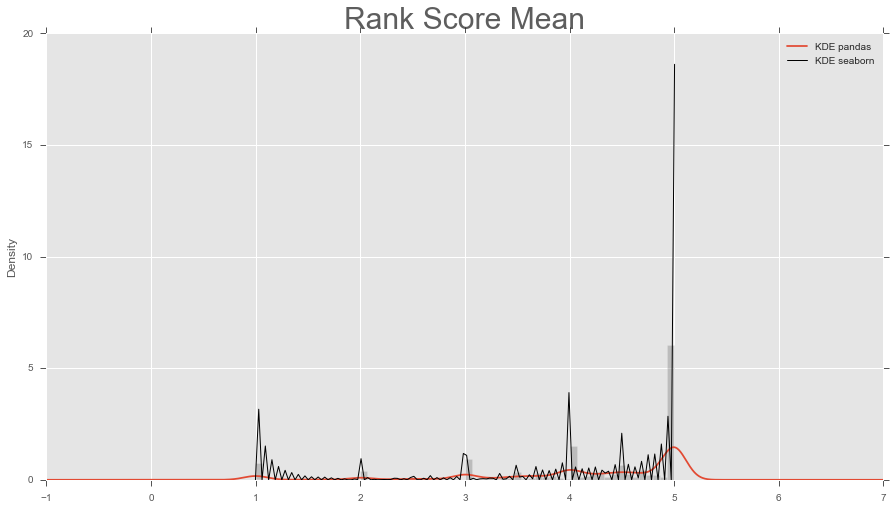

In [33]:
fig, ax = plt.subplots(figsize=(15,8))
productDf.ScoreMean.hist(bins=60, normed=True, alpha=0.4, color='grey')
productDf.ScoreMean.plot(kind='kde', title='Rank Score Mean by Product', label='KDE pandas')
sns.kdeplot(productDf.ScoreMean, bw=0.001, color='black', lw=1.0, label='KDE seaborn')
plt.title('Rank Score Mean', alpha=0.75, fontsize=30)

The answer is easy to see. Most products receive 5 rank.

** Rank Score Sum by Product **

To see it more clearly, we can use a bar chart.

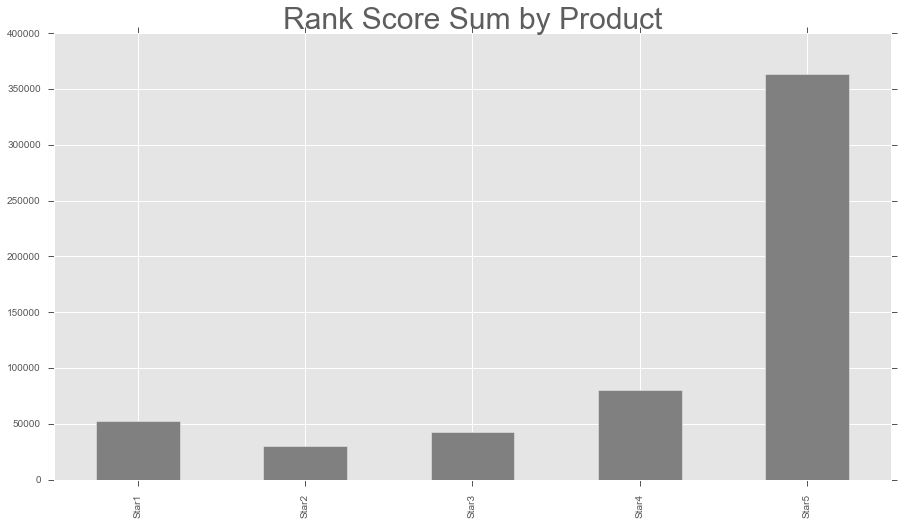

In [34]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('Rank Score Sum by Product', alpha=0.75, fontsize=30)
productDf[['Star1','Star2','Star3','Star4','Star5']].sum().plot(kind='bar',color='grey')

The result shows that the number of products which receive star 5 is 6 times more than that receive star 4.

#### 6.2 User Activation Analysis

** Rank Score Mean by User **

Now we will see some results of users. The first question is similar to the previous one, but the target is changed on the users. What rank do the users like to give?

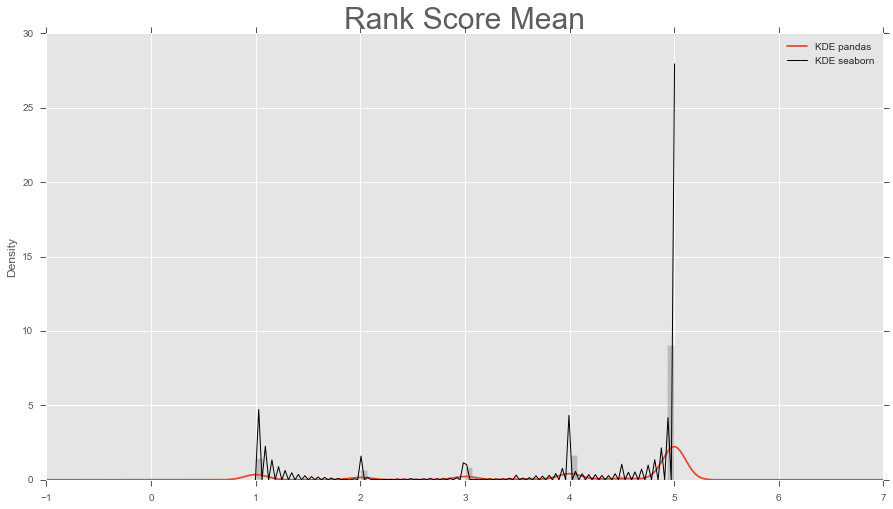

In [35]:
fig, ax = plt.subplots(figsize=(15,8))
userDf.ScoreMean.hist(bins=60, normed=True, alpha=0.4, color='grey')
userDf.ScoreMean.plot(kind='kde', title='Rank Score Mean', label='KDE pandas')
sns.kdeplot(userDf.ScoreMean, bw=0.001, color='black', lw=1.0, label='KDE seaborn')
plt.title('Rank Score Mean', alpha=0.75, fontsize=30)

The result is quite obvious that rank 5 take the biggest proportion. Actually, the result can be inferred from previous questions. Because the ranks of different products are received from users, there should have a strong relationship between the result of products and users.

We can also see some other information from the diagram. The proportion of rank 5 in user's picture is about 10 percent while that in products picture is only 6 percent, the same situation can be found on rank 1, too. We can infer that users prefer to give either 1 or 5 stars on products.

** Relationship between Helpfulness and Score **

The next question is interesting, which comment will you trust? Score 5 or score 1? In our opinion, star 1 is reliable because they are not easy to make up.

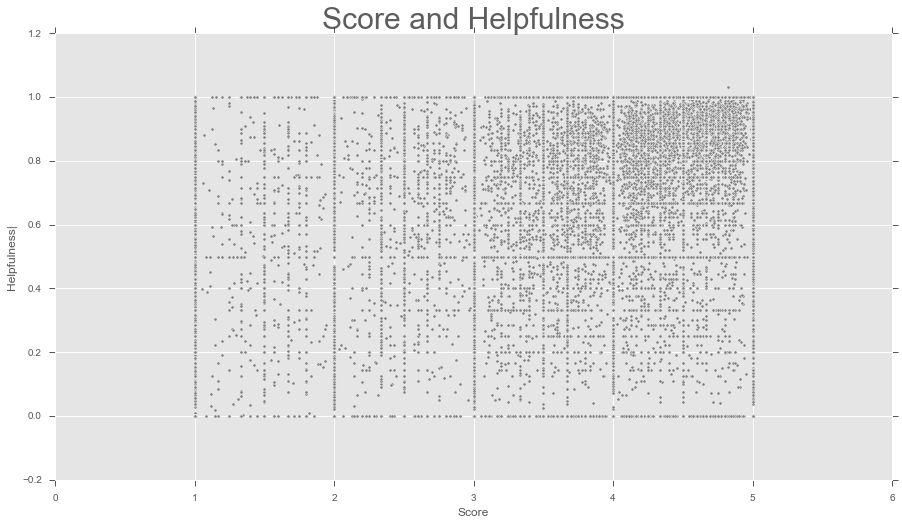

In [36]:
userDf['HelpfulnessPercent']=userDf['HelpfulnessNumerator']/userDf['HelpfulnessDenominator']
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(userDf['ScoreMean'], userDf['HelpfulnessPercent'],c='grey',s=10)
plt.title('Score and Helpfulness', alpha=0.75, fontsize=30)
ax.set_xlabel('Score')
ax.set_ylabel('Helpfulness|')

#### 6.3 Product Analysis

** Number of Food Product **

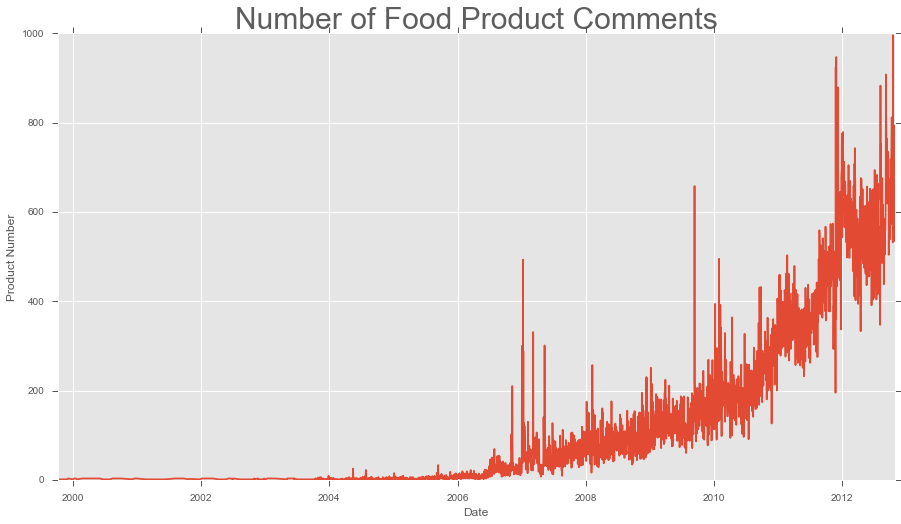

In [37]:
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(dateDf.index,dateDf['Products'])
plt.title('Number of Food Product Comments', alpha=0.75, fontsize=30)
ax.set_xlabel('Date')
ax.set_ylabel('Product Number')

The diagram is grouped by day, it can be seen that the number is increasing during this period.

** See it by year **

To see it more clearly, we will group it by year.

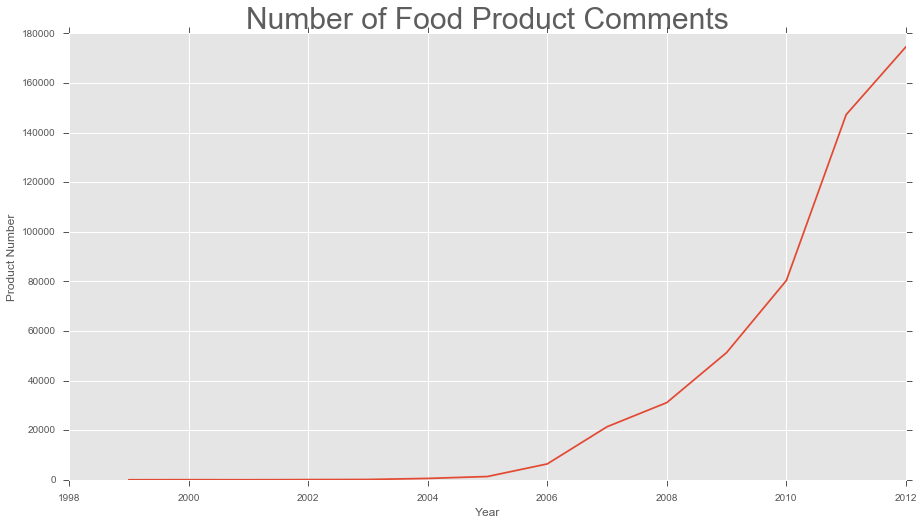

In [38]:
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(dateDf['Products'].groupby(dateDf.index.year).sum())
plt.title('Number of Food Product Comments', alpha=0.75, fontsize=30)
ax.set_xlabel('Year')
ax.set_ylabel('Product Number')

Now we can find that, the number of food product increased a lot from 1999 to 2012. It rose dramatically after 2010; nearly 100 thousand comments were added during this period.

** Score mean on different day of week **

The next question is that what is the relationship between days of week and scores? We think the scores on weekends should be higher because people may be happier on Saturday and Sunday. They are more likely to give a higher score.

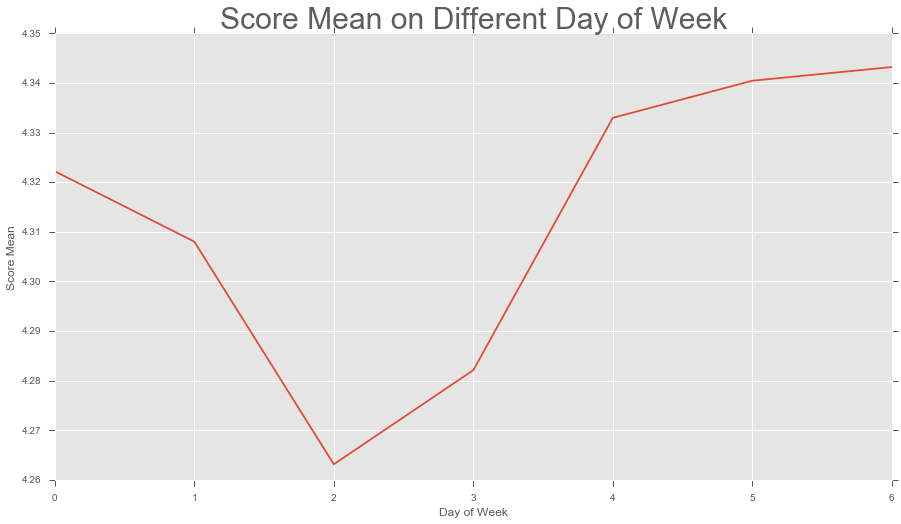

In [39]:
fig, ax = plt.subplots(figsize=(15,8))
dateDf['ScoreMean'].groupby(dateDf.index.dayofweek).mean().plot()
plt.title('Score Mean on Different Day of Week', alpha=0.75, fontsize=30)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Score Mean')

In this diagram, the x axis represents days of week. 0 means Monday while 6 means Sunday. We can see that on weekends, products will receive a higher score. Customers give the lowest score on Wednesday.

#### 6.4 Word Analysis

Next, we look at fine food reviews. Because the number of reviews are huge (about half million reviews), we will first analyze summaries (titles) of reviews, by doing word analyses and will show the most frequent words information. The first chart shows the 30 most frequent words in all titles of reviews, while the latter two charts display 30 most frequent words in 5-start and 1-start reviews respectively. 

As the number of words of 5-start titles is 0.8 million, very near the number of all titles (1.3 million), they have similar most frequent words. 

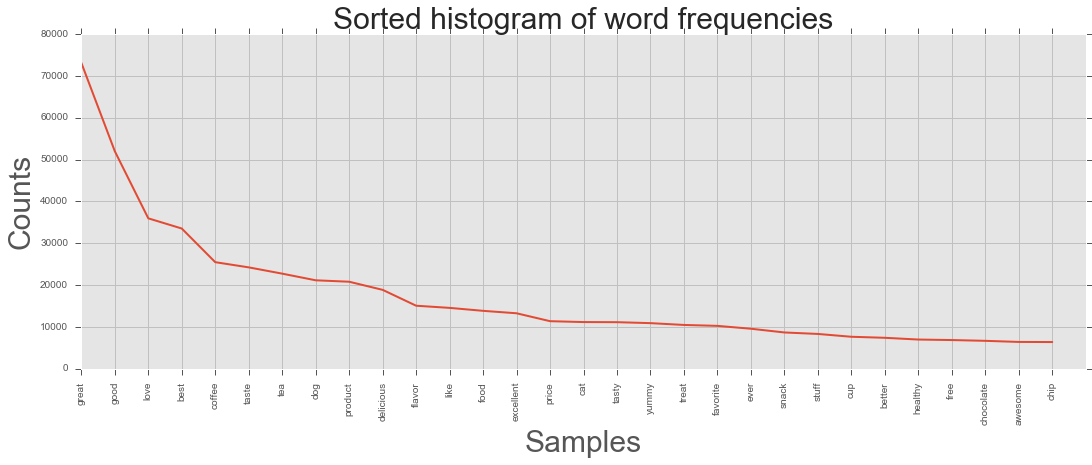

In [40]:
valid_text = word_analysis(all_summary)
f = plt.figure( figsize=(18, 6))
plt.xlabel('Samples', size=30)
plt.ylabel('Counts', size=30)
plt.title('Sorted histogram of word frequencies', size=30)
rcParams['xtick.labelsize'] = 20
valid_text.plot(30)

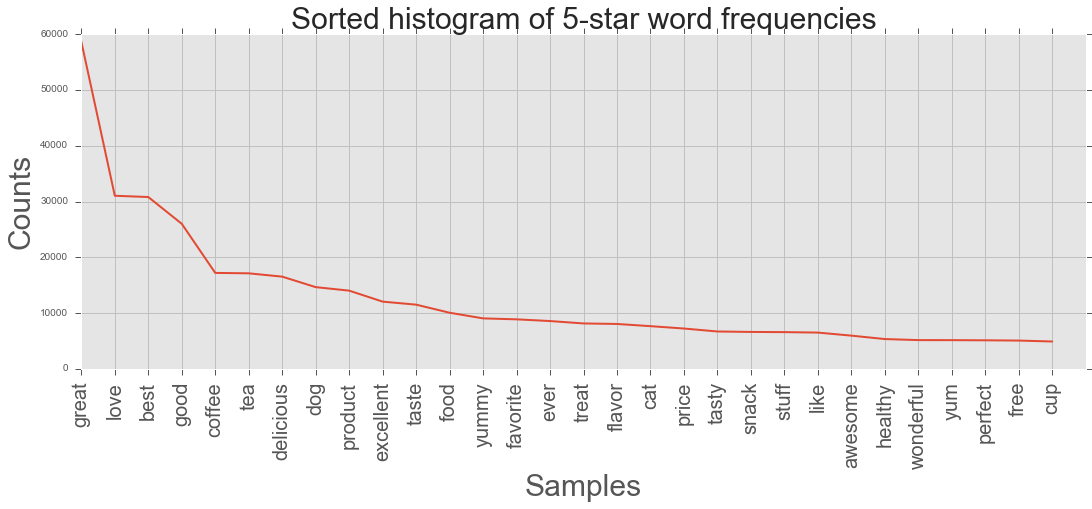

In [41]:
valid_text = word_analysis(start5_summary)
f = plt.figure( figsize=(18, 6))
plt.xlabel('Samples', size=30)
plt.ylabel('Counts', size=30)
plt.title('Sorted histogram of 5-star word frequencies', size=30)
rcParams['xtick.labelsize'] = 20
valid_text.plot(30)

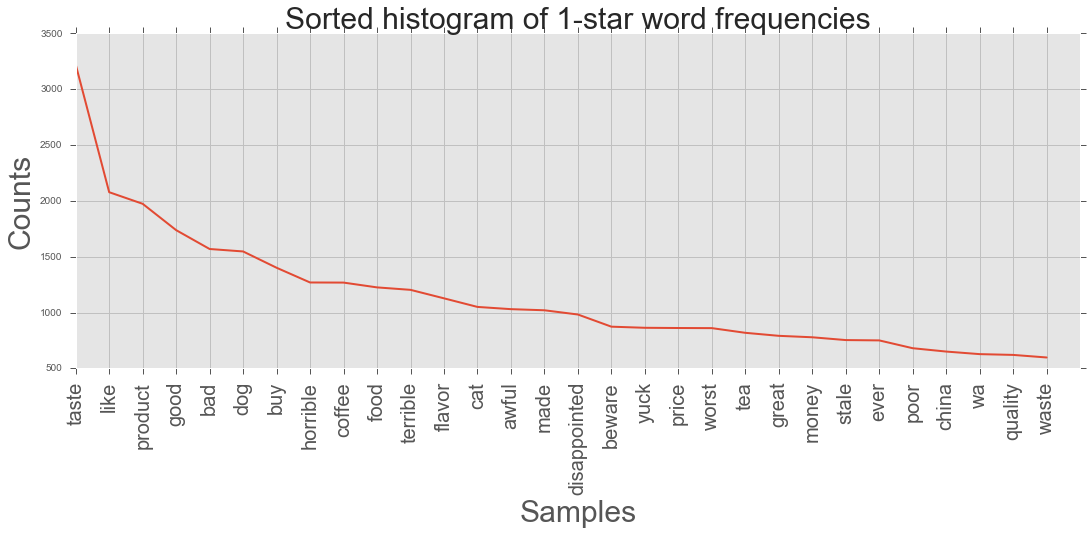

In [42]:
valid_text = word_analysis(start1_summary)
f = plt.figure( figsize=(18, 6))
plt.xlabel('Samples', size=30)
plt.ylabel('Counts', size=30)
plt.title('Sorted histogram of 1-star word frequencies', size=30)
rcParams['xtick.labelsize'] = 20
valid_text.plot(30)

### 7 Prediction

#### 7.1 Product Classification

At first, we will use Naive Bayes to predict the level of product by the users and reviews. We set three levels as the classes. The products whose average score is more than 4 belong to class 1, whose average score is more than 2 and smaller than 4 belong to class 2, and the rest belong to class 3. We have done it in data wrangling process.

** train_test **

At first, we need to create train dataset and test dataset. We set the test_size to 0.3

In [43]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(productDf[['Reviews','Users']], productDf['ScoreClass'], random_state=1, test_size=0.3)
nb = GaussianNB()


print X_train.shape
print X_test.shape

print y_train.shape
print y_test.shape


(51980, 2)
(22278, 2)
(51980L,)
(22278L,)


See the score of classifier.

In [44]:
classifier = nb.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

classifier.score(X_test, y_test)

0.21729957805907174

We can see it more detailed.

In [45]:
from sklearn import metrics

print metrics.classification_report(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

             precision    recall  f1-score   support

          1       0.70      0.22      0.33     14073
          2       0.36      0.00      0.00      6435
          3       0.10      0.99      0.18      1770

avg / total       0.55      0.22      0.23     22278

[[ 3081    27 10965]
 [ 1313    15  5107]
 [   25     0  1745]]


We can see the mean and STD of the predict.

In [46]:
from sklearn.cross_validation import cross_val_score
classifierNB = GaussianNB()
scores = cross_val_score(classifierNB, X_test, y_test, cv=5, scoring='accuracy')
print 'mean is: ', scores.mean()
print 'STD is: ', scores.std()

mean is:  0.229238686486
STD is:  0.0121324983483


However, we are not satisfied with the accuracy. It's only about 20 percent. We thought about it and got an assumption that there might be a strong relationship between the features that we picked: the reviews number and users number. The prediction model might have been overfitted. We decided to pick only one feature, i.e., the users number, and create a new model.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(productDf[['Users']], productDf['ScoreClass'], random_state=1, test_size=0.3)

print X_train.shape
print X_test.shape

print y_train.shape
print y_test.shape

(51980, 1)
(22278, 1)
(51980L,)
(22278L,)


See the score of classifier

In [48]:
classifier = nb.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

classifier.score(X_test, y_test)

0.63129544842445462

In [49]:
from sklearn import metrics

print metrics.classification_report(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

             precision    recall  f1-score   support

          1       0.63      1.00      0.77     14073
          2       0.34      0.00      0.00      6435
          3       0.00      0.00      0.00      1770

avg / total       0.50      0.63      0.49     22278

[[14054    19     0]
 [ 6425    10     0]
 [ 1770     0     0]]


E:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


This model is more reliable than before!

#### 7.2 User Clustering

We want to do cluster on the users data. We chose 'ScoreMean' and 'Reviews' as the features.

** Normalization the data **

In [50]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
minmax_scale = preprocessing.MinMaxScaler().fit(userDf[['ScoreMean','Reviews']])
userDf[['ScoreMean','Reviews']] = minmax_scale.transform(userDf[['ScoreMean','Reviews']])

We want to cluster the users to 3 clusters firstly.

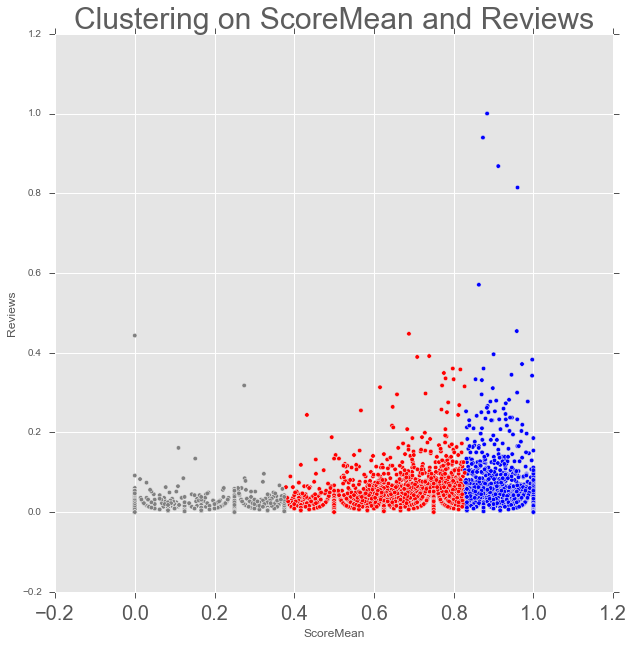

In [51]:
km = KMeans(n_clusters=3, init='random')
km.fit(userDf[['ScoreMean','Reviews']].values)
predictions=km.predict(userDf[['ScoreMean','Reviews']].values)

colors = np.array(['blue','red','grey'])
flg, ax=plt.subplots(figsize=(10,10))
plt.scatter(userDf.ix[:,'ScoreMean'], userDf.ix[:,'Reviews'],c = colors[predictions], s=20)
ax.set_xlabel('ScoreMean')
ax.set_ylabel('Reviews')
plt.title('Clustering on ScoreMean and Reviews', alpha=0.75, fontsize=30)

Use Silhouette Coefficient to see the result.

In [52]:
from sklearn import preprocessing

km = KMeans(n_clusters=3, init='random')
km.fit(userDf[['ScoreMean','Reviews']].values)
predictions = km.predict(userDf[['ScoreMean','Reviews']].values)
predictions

array([1, 1, 1, ..., 1, 1, 2])

In [53]:
from sklearn import metrics
metrics.silhouette_score(userDf[['ScoreMean','Reviews']].values, predictions,sample_size=10000)

0.8397985040382413

Visualize this property for a range of k values.

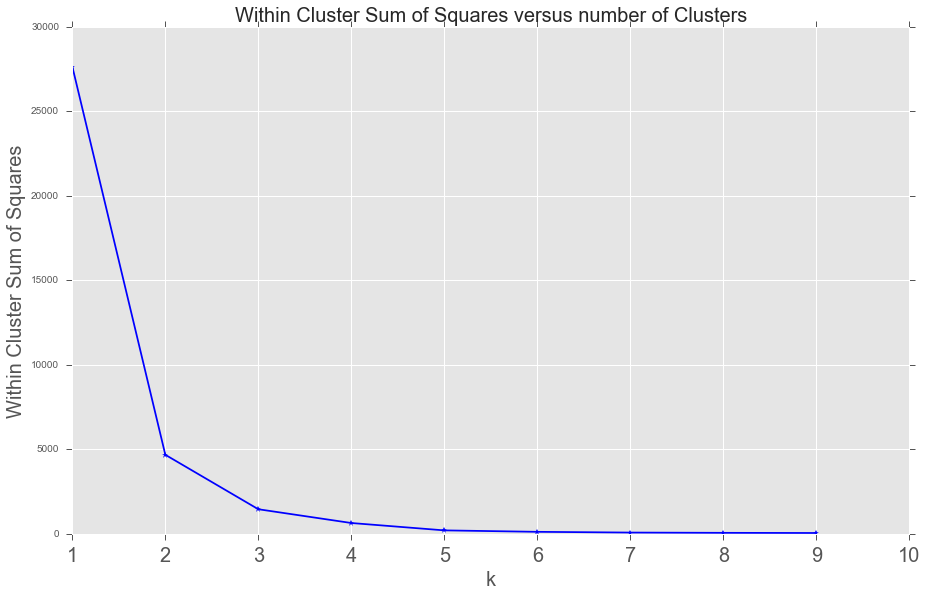

In [54]:
k_rng = range(1,10)
est = [KMeans(n_clusters = k).fit(userDf[['ScoreMean','Reviews']].values) for k in k_rng]

# Generally want to minimize WSS, while also minimizing k
within_cluster_sum_squares = [e.inertia_ for e in est]
fig, axes = plt.subplots()
fig.set_size_inches(15,20)
# Plot the results
plt.subplot(212)
plt.plot(k_rng, within_cluster_sum_squares, 'b*-')
plt.xlim([1,10])
plt.grid(True)
plt.xlabel('k', fontsize=20)
plt.ylabel('Within Cluster Sum of Squares', fontsize=20)
plt.title('Within Cluster Sum of Squares versus number of Clusters', fontsize=20)

In this topic, we cluster the dataset into three clusters. We think the three clusters represent different styles of commenting. The first cluster whose score is high represent users who prefer give a higher rank on products, which can attract more reviews. The second cluster represents users who usually give a 'middle' score on products. The third one represents users who often give only 1 star on products.

#### 7.3 kNN Prediction

In this topic, we will use kNN to predict what we have done in 7.1. We will set test_size to 0.3.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(productDf[['Reviews','Users']], productDf['ScoreClass'], random_state=1, test_size=0.3)

In [56]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

** Find the Best K **

Here is the graph to find Best K, to see it clearly, we will print the score before the graph.

2:0.422659125595
3:0.364889128288
4:0.634482449053
5:0.633719364395
6:0.633494927731
7:0.618637220576
8:0.423826196247
9:0.419427237634


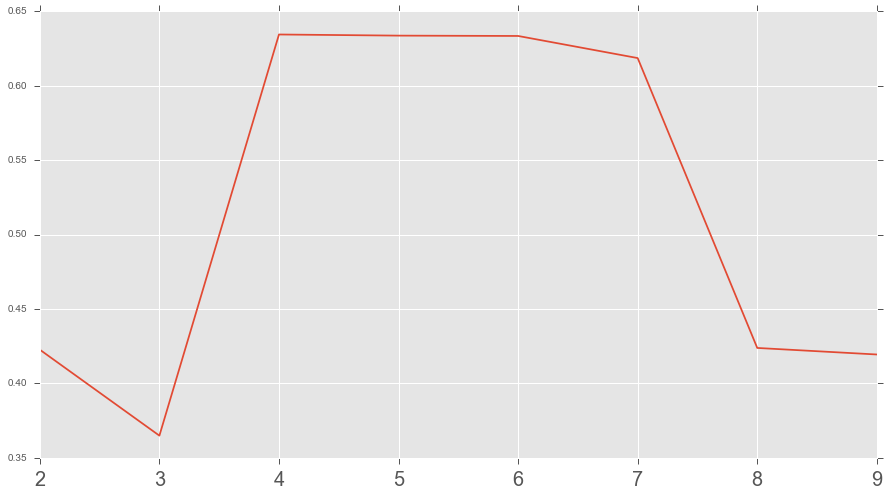

In [57]:
score_arr=[]
for i in range(2,10):
    knn = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
    knn.fit(X_train, y_train)
    score_arr.append(knn.score(X_test, y_test))
    print str(i)+":"+str(knn.score(X_test, y_test))
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(range(2,10),score_arr)

We can see from the diagram that the best k is 4. So we will change k to 4 and see it more detailed.

In [58]:
knn = KNeighborsClassifier(n_neighbors=4, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [59]:
knn = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
knn.score(X_test, y_test)

from sklearn import metrics
print metrics.classification_report(y_test, y_pred)


             precision    recall  f1-score   support

          1       0.63      1.00      0.77     14073
          2       0.62      0.02      0.03      6435
          3       0.00      0.00      0.00      1770

avg / total       0.58      0.63      0.50     22278



On this topic, we use kNN to predict score class on by Reviews and Users. In 7.1, we deleted one feature because the accuracy score was not high enough. However, in kNN progress, the situation did not come up again. We think kNN might perform better on overfitting situation than Naive Bayes.

#### 7.4 Score on Sentiment Analysis

Different customers had different sentiment when they wrote reviews. Some people were very satisfied with their products and gave high scores and wrote positive reviews for their products. By contract, other people were not content and gave low scores and wrote negative reviews.

We will try to extract summaries of reviews with highest scores (5) and lowest scores (1) and use different methods to predict scores against summaries.

First, we will extract reviews with 5 and 1 scores from the review data frame.

In [60]:
# create a new DataFrame that only contains the 5-star and 1-star reviews
review_best_worst = reviewDf[(reviewDf.Score==5) | (reviewDf.Score==1)][['Score', 'Summary']]
review_best_worst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415390 entries, 0 to 568453
Data columns (total 2 columns):
Score      415390 non-null int64
Summary    415390 non-null object
dtypes: int64(1), object(1)
memory usage: 9.5+ MB


Then we will choose the first method, using MultinomialNB class to train our model on the whole data set. The result accuracy is 0.945 on 28516 features.

In [61]:
X_train = review_best_worst.Summary.values
y_train = review_best_worst.Score.values

#Initialises an object of count vectorizers
# rows are documents, columns are terms (aka "tokens" or "features")
#It adds features to the review to represent all words in the dataset. = sparse matrix.
#most counts will be zero.
# use CountVectorizer to create document-term matrices from X_train and X_test
vect = CountVectorizer()
train_dtm = vect.fit_transform(X_train)
print 'Features: ', train_dtm.shape[1]

#We use MultinomialNB since we are dealing with counts
nb = MultinomialNB()
nb.fit(train_dtm, y_train)

y_pred_class = nb.predict(train_dtm)
print 'Accuracy: ', metrics.accuracy_score(y_train, y_pred_class)

Features:  28516
Accuracy:  0.945005898072


Next, we will choose the second method, using MultinomialNB class to train our model on the 75% data set. The result is 0.941 on 25152 features, only a little decrease than the previous method.

In [62]:
# split the new DataFrame into training and testing sets
# Gives us 75 train : 25 test split
X_train, X_test, y_train, y_test = train_test_split(review_best_worst.Summary, review_best_worst.Score, random_state=1, train_size=0.75)

#Initialises an object of count vectorizers
# rows are documents, columns are terms (aka "tokens" or "features")
#It adds features to the review to represent all words (16825) in the dataset. = sparse matrix.
#most counts will be zero.
# use CountVectorizer to create document-term matrices from X_train and X_test
vect = CountVectorizer()
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)
print 'Features: ', train_dtm.shape[1]

#We use MultinomialNB since we are dealing with counts
nb = MultinomialNB()
nb.fit(train_dtm, y_train)

y_pred_class = nb.predict(test_dtm)
print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)


Features:  25152
Accuracy:  0.941009937601


Thirdly, we try to remove English stop words from the features and redo the 75% training and 25% test. The result is 0.936 on 24871 features, another little decrease on accuracy.

In [63]:
# remove English stop words
vect = CountVectorizer(stop_words='english')
train_dtm = vect.fit_transform(X_train)
print 'Features: ', train_dtm.shape[1]
test_dtm = vect.transform(X_test)
nb = MultinomialNB()
nb.fit(train_dtm, y_train)
y_pred_class = nb.predict(test_dtm)
print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)


Features:  24871
Accuracy:  0.936830752638


Finally, we redo the test with only 100 features. The result accuracy is 0.872, a large plunge, which shows that the more features we use, the more accurate the result is.

In [64]:
# remove English stop words and only keep 100 features
vect = CountVectorizer(stop_words='english', max_features=100)
train_dtm = vect.fit_transform(X_train)
print 'Features: ', train_dtm.shape[1]
test_dtm = vect.transform(X_test)
nb = MultinomialNB()
nb.fit(train_dtm, y_train)
y_pred_class = nb.predict(test_dtm)
print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)


Features:  100
Accuracy:  0.872178568677


#### 7.5 Polarity and Subjectivity Analysis

All reviews have polarities and subjectivities. We will predict the polarity and subjectivity of every review by its content and therefore try to find out whether there are relationships between polarities/subjectivities and scores.

** Polarity and Score Prediction **

Firstly, we will calculate the polarities from review contents and store them into a new field in the review data frame. The chart shows the boxplot between scores and polarities. We can say that the higher scores are, the more polarities the customers expressed. We think that people would like to show their fancy about their products.

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

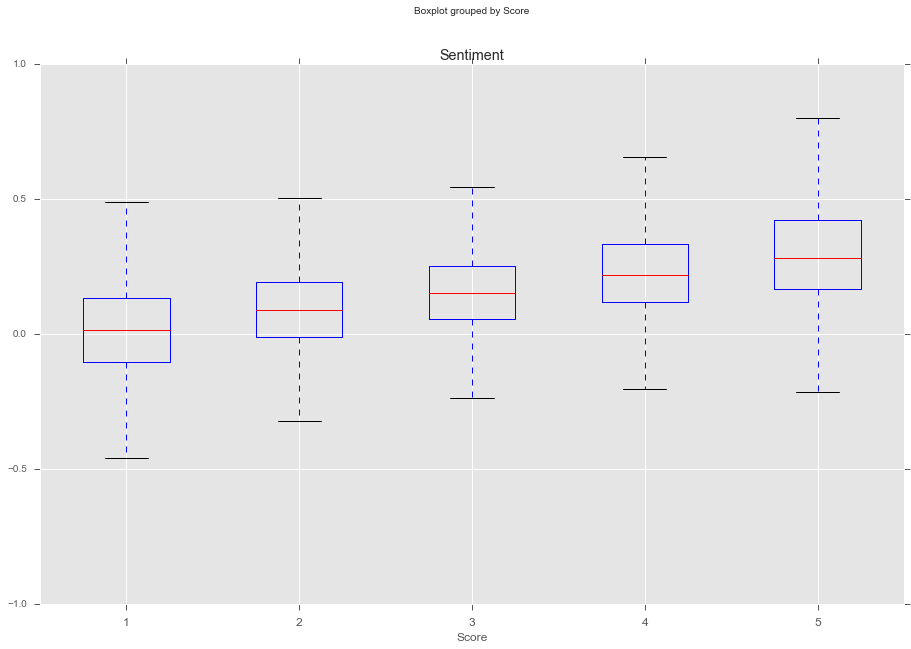

In [65]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity


# create a new DataFrame column for sentiment
reviewDf['Sentiment'] = reviewDf.Text.apply(detect_sentiment)

# boxplot of sentiment grouped by stars
reviewDf.boxplot(column='Sentiment', by='Score')
plt.xticks(fontsize='large')

Secondly, we will predict estimated scores from polarities and compare them with true scores. The result is good that we get 0.883 only on three features.

In [66]:
# create a new DataFrame that only contains the 5-star and 1-star reviews
review_best_worst = reviewDf[(reviewDf.Score==5) | (reviewDf.Score==1)][['Score', 'Sentiment', 'HelpfulnessNumerator', 'HelpfulnessDenominator']]

# split the new DataFrame into training and testing sets
feature_cols = ['Sentiment', 'HelpfulnessNumerator', 'HelpfulnessDenominator']
X = review_best_worst[feature_cols]
y = review_best_worst.Score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print 'Features: ', X_train.shape[1]
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_class = nb.predict(X_test)
print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)


Features:  3
Accuracy:  0.883550959094


** Subjectivity and Score Prediction **

Firstly, we will calculate the subjectivities from review contents and store them into a new field in the review data frame. The chart shows the boxplot between scores and subjectivities. We can say that subjectivities have no apparent relations with scores. Whether or not people are satisfied with their products, they can express their feelings in an objective way.

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

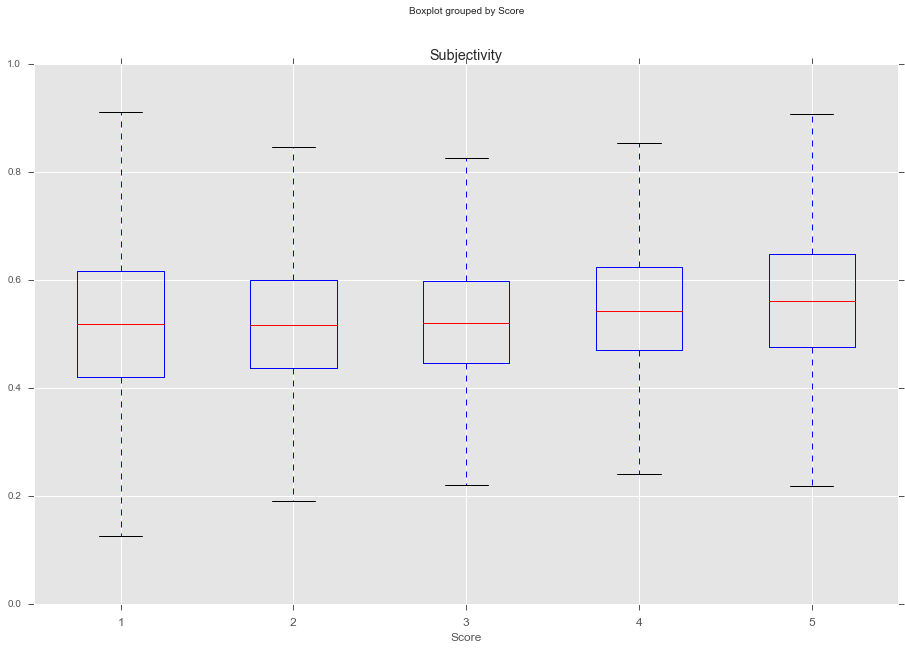

In [67]:
# define a function that accepts text and returns the subjectivity
def detect_sentiment2(text):
    return TextBlob(text.decode('utf-8')).sentiment.subjectivity


# create a new DataFrame column for sentiment
reviewDf['Subjectivity'] = reviewDf.Text.apply(detect_sentiment2)

# boxplot of sentiment grouped by stars
reviewDf.boxplot(column='Subjectivity', by='Score')
plt.xticks(fontsize='large')

Secondly, we will predict estimated scores from subjectivities and compare them with true scores. The result is good that we get 0.866 only on three features.

In [68]:
# create a new DataFrame that only contains the 5-star and 1-star reviews
review_best_worst = reviewDf[(reviewDf.Score==5) | (reviewDf.Score==1)][['Score', 'Subjectivity', 'HelpfulnessNumerator', 'HelpfulnessDenominator']]

# split the new DataFrame into training and testing sets
feature_cols = ['Subjectivity', 'HelpfulnessNumerator', 'HelpfulnessDenominator']
X = review_best_worst[feature_cols]
y = review_best_worst.Score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print 'Features: ', X_train.shape[1]
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_class = nb.predict(X_test)
print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)


Features:  3
Accuracy:  0.866680147908


In [69]:
reviewDf.to_csv('Reviews_Cleaned.csv')


#### 7.6 Document Similarity

Next, we will go no focusing on review contents. Because of the huge amount of contents, we cannot analyse them all. Alternatively, we can analyse a few of these documents to find out the similar ones. Therefore, we will pick out ten random documents and extract their id, author id and content.

In [70]:
temp_dict = {}
articles_dict = {}
articles_list = []
np.random.seed(0)#results differ if the seed is changed
for i in range(10):#extract 10 random documents from yelp
    idx = np.random.randint(0, len(reviewDf))
    review_text = unicode(reviewDf.Text[idx], 'utf-8')
    review_id = reviewDf.Id[idx]
    user_id = reviewDf.UserId[idx]
    temp_dict = {'review_id': review_id,
                'user_id' : user_id,
                'content' : review_text}
    articles_dict[str(i)] = temp_dict
    articles_list.append(temp_dict)
    print i
    print review_id
    print '======'
    print review_text
    print ''

0
305712
Tomato Basil is delicious. Priced a little too high. This might encourage a return to another source for product . . . although Amazon is clearly the most convenient & wanna stick with Amazon. Would have given this more "stars" if price were right. For canned soup,if rating solely by taste, give it a 4+.

1
435830
If you think of this as good for you candy, it is ok.  They contain doses of several B vitamins and vitamin C.  As far as making you feel energized, they aren't an energy drink, but they do contain energy type vitamins. The taste is pretty good and I'm sure they are better for you than most candy.  They come in a convenient packaging that can be carried in your purse easily so you can grab when you like as a good alternative to hard candy.  Overall, they have some benefit and if you are in the market for a good way to get some extra vitamins, give these a try.

2
117953
I don't know what is with these 1-star reviewers who expected to be able to just shove this stuff 

You can see the content of these documents above. Now let us start our analysis by calculating the similarity between every document and show the result by list all documents, the most similar documents and the similarities.

In [71]:
all_articles = [article['content'].lower().split() for article in articles_list ]

# Provides tf, idf, and tf_idf abstractions for scoring
tc = nltk.TextCollection(all_articles)#TextCollection has the TFIDF implemented

pd.set_option('display.max_colwidth',1000)

#source https://github.com/ptwobrussell/Mining-the-Social-Web/blob/master/python_code/deprecated/buzz__cosine_similarity.py

# Compute a term-document matrix such that td_matrix[doc_title][term]
# returns a tf-idf score for the term in the document

td_matrix = {}

for idx in range(len(all_articles)):
    post = all_articles[idx]
    #print post
    fdist = nltk.FreqDist(post)

    doc_review_id = articles_list[idx]['review_id']
    user_id = articles_list[idx]['user_id']
    td_matrix[(doc_review_id, user_id)] = {}

    for term in fdist.iterkeys():
        td_matrix[(doc_review_id, user_id)][term] = tc.tf_idf(term, post)
        
# Build vectors such that term scores are in the same positions...
distances = {}
for (doc_review_id1, user_id1) in td_matrix.keys():

    distances[(doc_review_id1, user_id1)] = {}
    (min_dist, most_similar) = (1.0, ('', ''))

    for (doc_review_id2, user_id2) in td_matrix.keys():
        #print (doc_review_id1, doc_review_id2)
        # Take care not to mutate the original data structures
        # since we're in a loop and need the originals multiple times

        terms1 = td_matrix[(doc_review_id1, user_id1)].copy()
        terms2 = td_matrix[(doc_review_id2, user_id2)].copy()

        # Fill in "gaps" in each map so vectors of the same length can be computed
        for term1 in terms1:
            if term1 not in terms2:
                terms2[term1] = 0

        for term2 in terms2:
            if term2 not in terms1:
                terms1[term2] = 0

        # Create vectors from term maps
        v1 = [score for (term, score) in sorted(terms1.items())]
        v2 = [score for (term, score) in sorted(terms2.items())]

        # Compute similarity amongst documents
        dist = nltk.cluster.util.cosine_distance(v1, v2)
        distances[(doc_review_id1, user_id1)][(doc_review_id2, user_id2)] = nltk.cluster.util.cosine_distance(v1, v2)
        #print dist
        if user_id1 == user_id2:
            #print distances[(title1, url1)][(title2, url2)]
            continue

        if distances[(doc_review_id1, user_id1)][(doc_review_id2, user_id2)] < min_dist:
            (min_dist, most_similar) = (distances[(doc_review_id1, user_id1)][(doc_review_id2, user_id2)], (doc_review_id2, user_id2))
    print "================================================================================================================"
    print "================================================================================================================"
    print '''Most similar to %s \t%s \tscore %f ''' % (doc_review_id1, most_similar[0], min_dist)
    print reviewDf['Text'][reviewDf.Id==doc_review_id1]
    print "================================================================================================================"
    print reviewDf['Text'][reviewDf.Id==most_similar[0]]

Most similar to 374565 	435830 	score 0.972319 
374564    Walkers pure butter shortbread cookies are the best I"ve ever had. The 58.4 oz tin has 4 individually wraped trays of 24 cookies each tray to maintain freshness.Each tray could be a gift in itself.The tin can be reused for gift giving.Plus the price saves over smaller quanties.
Name: Text, dtype: object
435829    If you think of this as good for you candy, it is ok.  They contain doses of several B vitamins and vitamin C.  As far as making you feel energized, they aren't an energy drink, but they do contain energy type vitamins. The taste is pretty good and I'm sure they are better for you than most candy.  They come in a convenient packaging that can be carried in your purse easily so you can grab when you like as a good alternative to hard candy.  Overall, they have some benefit and if you are in the market for a good way to get some extra vitamins, give these a try.
Name: Text, dtype: object
Most similar to 305712 	310745 	sc

Finally, we will show the most similar documents by a graph below:

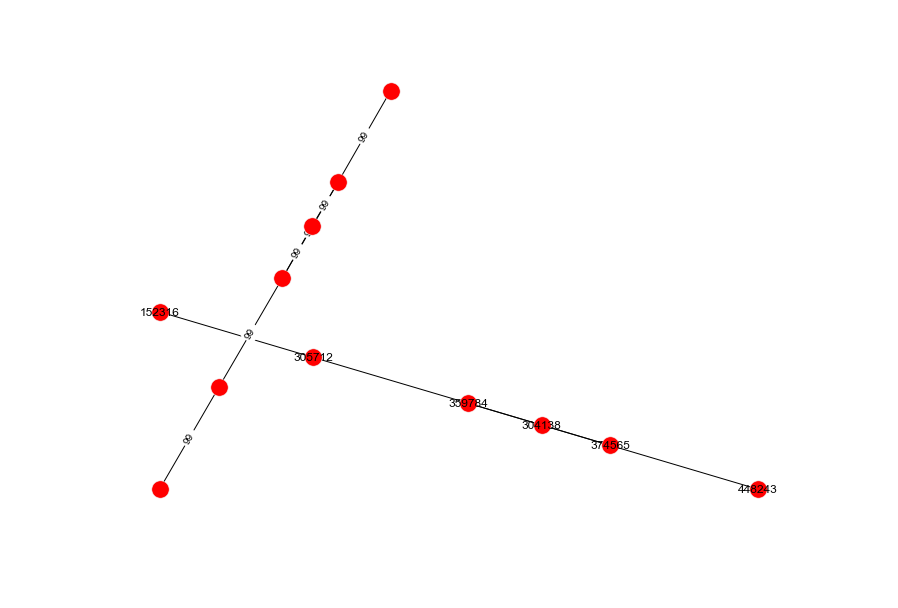

In [72]:
td_matrix = compute_tf_idf_document_matrix(articles_dict)
distances = compute_article_distances(td_matrix)


#create an empty graph
G = nx.Graph()

for k,v in distances.iteritems():
    for k2, v2 in v.iteritems():
        if v2>=0.99:
            G.add_edge(k, k2);
            G[k][k2]['weight'] = v2*100;

# position the nodes by Force Layout
pos = nx.spring_layout(G)

#position the nodes according the output
# from the spring/force layout algorithm
edge_weight=dict([((u,v,),int(d['weight'])) for u,v,d in G.edges(data=True)])

nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_weight)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)

#spring is between spectral and circular
nx.draw_spring(G, with_labels=True)


### 8 Conclusion

In conclusion, we have done some analyses on customer reviews and used a few prediction models to do classification, clustering and nature language learning. So far, despite the huge volume of review data, we have got some useful results. We have trained the Naive Bayes model and predicted the product scores. The result is reasonable. 

Also we have done k-mean prediction and divided the users into different groups. The result is inspiring and can be used for customer relationship managers to maintain and improve customers' relations. 

Finally, the analyses and predictions on review titles and contents gave a lot of useful information, through which the product department could upgrade their product lines and develop new products to satisfy customers.

In [73]:
%%javascript
require(['base/js/utils'],
function(utils) {
   utils.load_extensions('calico-spell-check');
});

<IPython.core.display.Javascript object>